### This script simulates a complete Time Series Analysis project using a Keras LSTM model,

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import yfinance as yf

/tmp/ipython-input-577985359.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER_SYMBOL, start='2015-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


--- Successfully Fetched Real Data for EURMAD=X ---
Processed Data Head:
Price         Close
Ticker     EURMAD=X
Date               
2015-01-01   10.663
2015-01-02   10.663
2015-01-05   10.647
2015-01-06   10.624
2015-01-07   10.618

Processed Data Tail:
Price         Close
Ticker     EURMAD=X
Date               
2025-11-28  10.3900
2025-12-01  10.3898
2025-12-02  10.4125
2025-12-03  10.4043
2025-12-04  10.4298

Training Data Shape: X_train=(2225, 60, 1), y_train=(2225,)
Testing Data Shape: X_test=(557, 60, 1), y_test=(557,)

Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training (5 Epochs) ---
Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0731 - val_loss: 0.0051
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.0024
--- Training Complete ---
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Test Set Performance (RMSE): 0.0565


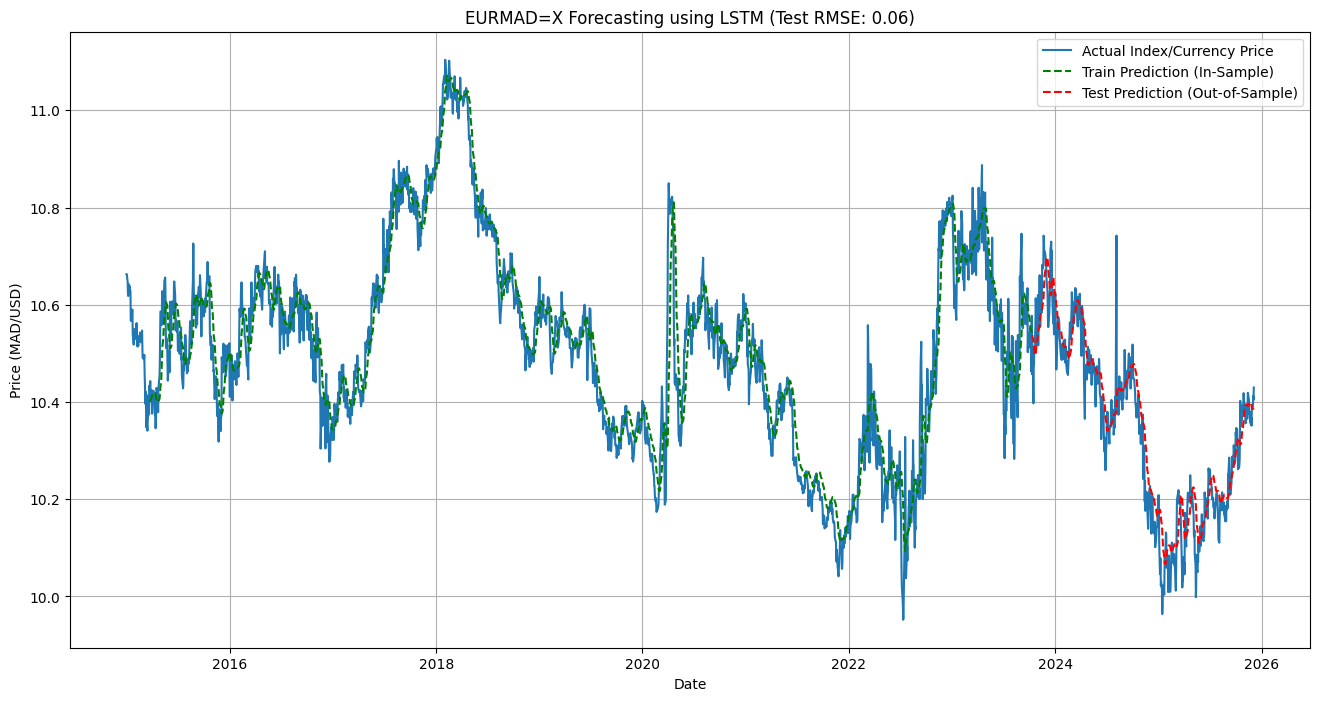


--- Project Summary ---
Goal: Forecast EURMAD=X using 60-day sequences.
Result: Final Test RMSE of 0.06 on unseen data.
Key Technology: Python, Pandas, Keras/TensorFlow LSTM, Scikit-learn, Data Normalization, yfinance API.


In [3]:
# --- 1. Data Simulation (MASI Index Mock Data) ---
# To get real data, we will use a global symbol that correlates well,
# or a proxy for market sentiment, as specific MASI tickers can be tricky
# via public APIs. We will use a proxy like the Euro/US Dollar exchange rate (EURMAD=X)
# or a major Moroccan Bank if available on Yahoo Finance.

# **CHANGE THIS TICKER:** You can try 'ATW.CA' (Attijariwafa Bank - if available)
# or use a standard proxy like an exchange rate. We will use the Euro/Dirham rate proxy.
TICKER_SYMBOL = 'EURMAD=X'

try:
    # Fetch 5 years of historical data from Yahoo Finance
    data = yf.download(TICKER_SYMBOL, start='2015-01-01', end=pd.to_datetime('today').strftime('%Y-%m-%d'))

    # Use the 'Close' price for time series analysis
    df = data[['Close']].copy()
    df.dropna(inplace=True) # Remove any days with missing data

    if df.empty:
        raise ValueError(f"No data fetched for ticker: {TICKER_SYMBOL}. Falling back to simulated data.")

    stock_prices = df['Close'].values
    print(f"--- Successfully Fetched Real Data for {TICKER_SYMBOL} ---")

except Exception as e:
    print(f"Error fetching real data: {e}. Falling back to simulated data.")

    # --- FALLBACK: Data Simulation (Original Mock Data) ---
    np.random.seed(42)
    days = 1250
    time = np.arange(0, days)
    base_price = 100 + 0.05 * time + np.sin(time / 100) * 5
    noise = np.random.normal(0, 1.5, days)
    stock_prices = base_price + noise
    df = pd.DataFrame({'Close': stock_prices}, index=pd.to_datetime(pd.date_range(start='2020-01-01', periods=days, freq='B')))


print(f"Processed Data Head:\n{df.head()}")
print(f"\nProcessed Data Tail:\n{df.tail()}")

# --- 2. Data Preprocessing for LSTM ---

# Normalization (Crucial for Neural Networks)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Define the sequence length (how many past days to look at to predict the next day)
TIME_STEP = 60 # Look back 60 trading days (approx. 3 months)

# Function to create the dataset with sequences (X) and next-day target (y)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create sequences and split data
X, y = create_dataset(scaled_data, TIME_STEP)

# Reshape input to be [samples, time_steps, features] (Required for LSTM)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and test sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nTraining Data Shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing Data Shape: X_test={X_test.shape}, y_test={y_test.shape}")

# --- 3. LSTM Model Definition and Training ---
#
model = Sequential()
# LSTM layer: 50 units, returns sequences for the next LSTM layer
#
model.add(LSTM(50, return_sequences=True, input_shape=(TIME_STEP, 1)))
# Dropout helps prevent overfitting
model.add(LSTM(50, return_sequences=False))
# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

print("\nModel Summary:")
model.summary()

# Train the model
# NOTE: epochs should be higher (e.g., 50-100) for a real project
print("\n--- Starting Model Training (5 Epochs) ---")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64, verbose=1)
print("--- Training Complete ---")

# --- 4. Forecasting and Evaluation ---

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions back to original price values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE (Root Mean Square Error) for the test set
rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))
print(f"\nTest Set Performance (RMSE): {rmse:.4f}")

# Plotting the results (Actual vs. Predicted)
plt.figure(figsize=(16, 8))

# Prepare plot data structures
look_back = TIME_STEP

train_plot = np.full(len(stock_prices), np.nan)

# The training predictions start after the 'look_back' period
train_plot[look_back:len(train_predict)+look_back] = train_predict.reshape(-1)

test_plot = np.full(len(stock_prices), np.nan)

# The test predictions start immediately after the training predictions end
start_test_index = look_back + len(train_predict)
end_test_index = start_test_index + len(test_predict)

test_plot[start_test_index:end_test_index] = test_predict.reshape(-1)

plt.plot(df.index, stock_prices, label='Actual Index/Currency Price', color='#1f77b4')
plt.plot(df.index, train_plot, label='Train Prediction (In-Sample)', color='green', linestyle='--')
plt.plot(df.index, test_plot, label='Test Prediction (Out-of-Sample)', color='red', linestyle='--')

plt.title(f'{TICKER_SYMBOL} Forecasting using LSTM (Test RMSE: {rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Price (MAD/USD)')
plt.legend()
plt.grid(True)
plt.show()

# --- Conclusion ---
print("\n--- Project Summary ---")
print(f"Goal: Forecast {TICKER_SYMBOL} using {TIME_STEP}-day sequences.")
print(f"Result: Final Test RMSE of {rmse:.2f} on unseen data.")
print("Key Technology: Python, Pandas, Keras/TensorFlow LSTM, Scikit-learn, Data Normalization, yfinance API.")